# Intelligent Systems (SInt) - Group Project

## **Fuzzy Data Analysis with Multi-Method Classification for Predicting Heart Disease**

Group No.: 9

Students:
- Pedro Geitoeira, No. 87489
- Eloy Marquesan Dones, No. 112861

**GitHub**: [SInt_G09](https://github.com/pedrogeitoeira/SInt_G09.git)

## Neural Networks - Multilayer Perceptron (MLP)

### Imports

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, confusion_matrix
from sklearn.pipeline import Pipeline

### Data Preprocessing

In [90]:
# Load the dataset.
data = pd.read_csv('data/heart_disease.csv')

# Extract the variable names.
var_names = data.columns

# Print the original variable names.
print('Variable names:')
for var in var_names:
    print(var)

Variable names:
age
sex
cp
trestbps
chol
fbs
restecg
thalach
exang
oldpeak
slope
ca
thal
target


In [91]:
# Manually provide the updated variable names.
new_var_names = ['Age',
                 'Sex',
                 'ChestPainType',
                 'RestingBloodPressure',
                 'SerumCholesterol',
                 'FastingBloodSugar',
                 'RestingElectrocardiographicResults',
                 'MaximumHeartRateAchieved',
                 'ExerciseInducedAngina',
                 'Oldpeak',
                 'SlopeOfThePeakExerciseSTSegment',
                 'NumberOfMajorVessels',
                 'Thal',
                 'HeartDisease']

# Update the column names in the dataset.
data.columns = new_var_names

# Print the updated variable names.
print('Updated variable names:')
for var in data.columns:
    print(var)

Updated variable names:
Age
Sex
ChestPainType
RestingBloodPressure
SerumCholesterol
FastingBloodSugar
RestingElectrocardiographicResults
MaximumHeartRateAchieved
ExerciseInducedAngina
Oldpeak
SlopeOfThePeakExerciseSTSegment
NumberOfMajorVessels
Thal
HeartDisease


In [92]:
# Check for the presence of NaN values and determine if there are any non-numeric entries.
nan_check = data.isna().sum() # Check for the presence of NaN values.
non_numeric_check = data.apply(lambda col: col.map(lambda x: isinstance(x, str)).sum()) # Check for the presence of string entries.

# Print the number of NaN entries in each variable column.
print('Number of NaN entries in each variable column:')
for column, count in nan_check.items():
    print(f'{column}: {count}')

# Print the number of non-numeric entries in each variable column.
print('\nNumber of non-numeric entries in each variable column:')
for column, count in non_numeric_check.items():
    print(f'{column}: {count}')

Number of NaN entries in each variable column:
Age: 0
Sex: 0
ChestPainType: 0
RestingBloodPressure: 0
SerumCholesterol: 0
FastingBloodSugar: 0
RestingElectrocardiographicResults: 0
MaximumHeartRateAchieved: 0
ExerciseInducedAngina: 0
Oldpeak: 0
SlopeOfThePeakExerciseSTSegment: 0
NumberOfMajorVessels: 0
Thal: 0
HeartDisease: 0

Number of non-numeric entries in each variable column:
Age: 0
Sex: 0
ChestPainType: 0
RestingBloodPressure: 0
SerumCholesterol: 0
FastingBloodSugar: 0
RestingElectrocardiographicResults: 0
MaximumHeartRateAchieved: 0
ExerciseInducedAngina: 0
Oldpeak: 0
SlopeOfThePeakExerciseSTSegment: 0
NumberOfMajorVessels: 0
Thal: 0
HeartDisease: 0


**The dataset appears to be clean**. It does not contain any NaN (missing) values or string (non-numeric) entries in any of the columns. Each entry in the dataset seems to be valid.

In [93]:
# Check for class imbalance.
class_distribution = data['HeartDisease'].value_counts(normalize = True)*100

# Format the class distribution as a percentage with two decimal places.
class_distribution = class_distribution.map('{:.2f}%'.format)

# Print the class distribution.
print('Class distribution:')
for index, value in class_distribution.items():
    print(f'{index}: {value}')

Class distribution:
1: 51.32%
0: 48.68%


**The dataset does not exhibit significant class imbalance**. The distribution between the two classes (1 and 0) is nearly even, indicating that special techniques, such as resampling (oversampling or undersampling) or class weighting, are unlikely to be necessary for handling class imbalance during the modeling process.

In [94]:
# # Extract the feature names.
# feature_names = data.columns[:-1]

# Convert the dataset to a numpy array.
data = data.to_numpy()

# Normalize the dataset to the range [0, 1].
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Assign the X and y for the classification problem.
X = data[:, :-1] # All columns except the last one as input features.
y = data[:, -1] # The last column as the target (Heart Disease).

# Split the dataset into training and testing sets while preserving class distribution.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

**The dataset was normalized to a range of 0 to 1 to ensure features are on comparable scales**. For neural networks, such as Multi-Layer Perceptrons (MLPs), normalization is critical to ensure efficient training. MLPs use gradient-based optimization, and without normalization, features on different scales can lead to uneven gradients, causing slower convergence, unstable training, or getting stuck in local minima. Normalization addresses these issues by ensuring that all features contribute equally, resulting in faster and more stable convergence.

**The dataset was split into training and testing sets using an 80%-20% ratio**. **Stratification was applied during the split** to ensure that the class distribution was maintained across both sets.

### Model Training and Cross-Validation

In [95]:
# Set up the stratified k-fold cross-validation on the training set.
k = 5 # Number of folds.
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42) # 5-fold stratified cross-validation.

Talk about the Cross-Validation...

#### Without Feature Selection

In [96]:
# Define the Multi-Layer Perceptron (MLP) classifier model.
mlp = MLPClassifier(max_iter = 1000, random_state = 42)

# Define the parameter grid to be searched by the GridSearchCV.
parameter_grid = {'hidden_layer_sizes': [(nr_neurons,) for nr_neurons in range(2, 22, 2)]
                  + [(nr_neurons, nr_neurons) for nr_neurons in range(2, 22, 2)]}

# Define the scoring metrics to be captured during the GridSearchCV.
scoring = {'accuracy': make_scorer(accuracy_score),
           'f1': make_scorer(f1_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'kappa': make_scorer(cohen_kappa_score)}

# Define the GridSearchCV object.
grid_search = GridSearchCV(estimator = mlp,
                           param_grid = parameter_grid,
                           scoring = scoring,
                           refit = 'f1', # Uses the F1-score to select the best model.
                           cv = skf,
                           return_train_score = True,
                           verbose = 1,
                           n_jobs= -1)

# Train and tune the model using the GridSearchCV.
grid_search.fit(X_train, y_train)

# Extract the best model, the best hyperparameter configuration, and the best validation F1-score
# found by the GridSearchCV.
best_model_full = grid_search.best_estimator_
best_configuration_full = grid_search.best_params_
best_f1_score_full = grid_search.best_score_

# Extract the results of the GridSearchCV.
cv_results_full = grid_search.cv_results_

# Extract and the mean and standard deviation of the validation performance metrics
# for the different hyperparameter configurations.
mean_acc_val_all = cv_results_full['mean_test_accuracy']
mean_rec_val_all = cv_results_full['mean_test_recall']
mean_prec_val_all = cv_results_full['mean_test_precision']
mean_F1_score_val_all = cv_results_full['mean_test_f1']
mean_kappa_val_all = cv_results_full['mean_test_kappa']
std_acc_val_all = cv_results_full['std_test_accuracy']
std_rec_val_all = cv_results_full['std_test_recall']
std_prec_val_all = cv_results_full['std_test_precision']
std_F1_score_val_all = cv_results_full['std_test_f1']
std_kappa_val_all = cv_results_full['std_test_kappa']

# Create a dictionary containing the mean and the standard deviation of the validation performance metrics
# for the different hyperparameter configurations.
metrics_dict_full = {'Accuracy': (mean_acc_val_all, std_acc_val_all),
                     'Recall': (mean_rec_val_all, std_rec_val_all),
                     'Precision': (mean_prec_val_all, std_prec_val_all),
                     'F1-Score': (mean_F1_score_val_all, std_F1_score_val_all),
                     'Kappa': (mean_kappa_val_all, std_kappa_val_all)}

# Extract the mean and standard deviation of the training accuracy and F1-score,
# as well as the hyperparameter configurations, for plotting purposes.
mean_acc_train_all = cv_results_full['mean_train_accuracy']
mean_F1_score_train_all = cv_results_full['mean_train_f1']
configurations = cv_results_full['param_hidden_layer_sizes']

# Print the mean and the standard deviation of the training and validation performance metrics
# for each hyperparameter configuration.
print('-'*50)
for i in range(len(configurations)):
    nr_layers = len(configurations[i])
    nr_neurons = configurations[i][0]
    print(f'Configuration (hidden layer structure): {nr_layers} hidden layers with {nr_neurons} neurons each')

    print('\nAverage performance metrics (training):')
    print(f'- Accuracy: {cv_results_full['mean_train_accuracy'][i]:.3f} ± {cv_results_full['std_train_accuracy'][i]:.3f}')
    print(f'- Recall: {cv_results_full['mean_train_recall'][i]:.3f} ± {cv_results_full['std_train_recall'][i]:.3f}')
    print(f'- Precision: {cv_results_full['mean_train_precision'][i]:.3f} ± {cv_results_full['std_train_precision'][i]:.3f}')
    print(f'- F1-Score: {cv_results_full['mean_train_f1'][i]:.3f} ± {cv_results_full['std_train_f1'][i]:.3f}')
    print(f'- Kappa: {cv_results_full['mean_train_kappa'][i]:.3f} ± {cv_results_full['std_train_kappa'][i]:.3f}')
    print('\nAverage performance metrics (validation):')
    print(f'- Accuracy: {cv_results_full['mean_test_accuracy'][i]:.3f} ± {cv_results_full['std_test_accuracy'][i]:.3f}')
    print(f'- Recall: {cv_results_full['mean_test_recall'][i]:.3f} ± {cv_results_full['std_test_recall'][i]:.3f}')
    print(f'- Precision: {cv_results_full['mean_test_precision'][i]:.3f} ± {cv_results_full['std_test_precision'][i]:.3f}')
    print(f'- F1-Score: {cv_results_full['mean_test_f1'][i]:.3f} ± {cv_results_full['std_test_f1'][i]:.3f}')
    print(f'- Kappa: {cv_results_full['mean_test_kappa'][i]:.3f} ± {cv_results_full['std_test_kappa'][i]:.3f}')
    print('-'*50)

# Print the best hyperparameter configuration and the best validation F1-Score.
best_nr_layers_full = len(best_configuration_full['hidden_layer_sizes'])
best_nr_neurons_full = best_configuration_full['hidden_layer_sizes'][0]
print(f'\nBest configuration (hidden layer structure): {best_nr_layers_full} hidden layers with {best_nr_neurons_full} neurons each')
print(f'Best validation F1-Score: {best_f1_score_full:.3f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


--------------------------------------------------
Configuration (hidden layer structure): 1 hidden layers with 2 neurons each

Average performance metrics (training):
- Accuracy: 0.840 ± 0.006
- Recall: 0.895 ± 0.005
- Precision: 0.812 ± 0.008
- F1-Score: 0.852 ± 0.005
- Kappa: 0.679 ± 0.012

Average performance metrics (validation):
- Accuracy: 0.832 ± 0.020
- Recall: 0.881 ± 0.034
- Precision: 0.809 ± 0.021
- F1-Score: 0.843 ± 0.019
- Kappa: 0.662 ± 0.039
--------------------------------------------------
Configuration (hidden layer structure): 1 hidden layers with 4 neurons each

Average performance metrics (training):
- Accuracy: 0.856 ± 0.014
- Recall: 0.909 ± 0.012
- Precision: 0.828 ± 0.014
- F1-Score: 0.866 ± 0.012
- Kappa: 0.711 ± 0.028

Average performance metrics (validation):
- Accuracy: 0.848 ± 0.013
- Recall: 0.910 ± 0.020
- Precision: 0.816 ± 0.027
- F1-Score: 0.860 ± 0.010
- Kappa: 0.694 ± 0.027
--------------------------------------------------
Configuration (hidden l

Talk about GridSearchCV...

In [97]:
# Extract the indices of the configurations that only have one hidden layer.
one_layer_idx = [i for i, config in enumerate(configurations) if len(config) == 1]

# Extract the indices of the configurations that only have two hidden layers.
two_layer_idx = [i for i, config in enumerate(configurations) if len(config) == 2]

# Extract the number of neurons for the configurations with only one hidden layer.
nr_neurons_one_layer = [configurations[i][0] for i in one_layer_idx]

# Extract the number of neurons for the configurations with only two hidden layers.
nr_neurons_two_layer = [configurations[i][0] for i in two_layer_idx]

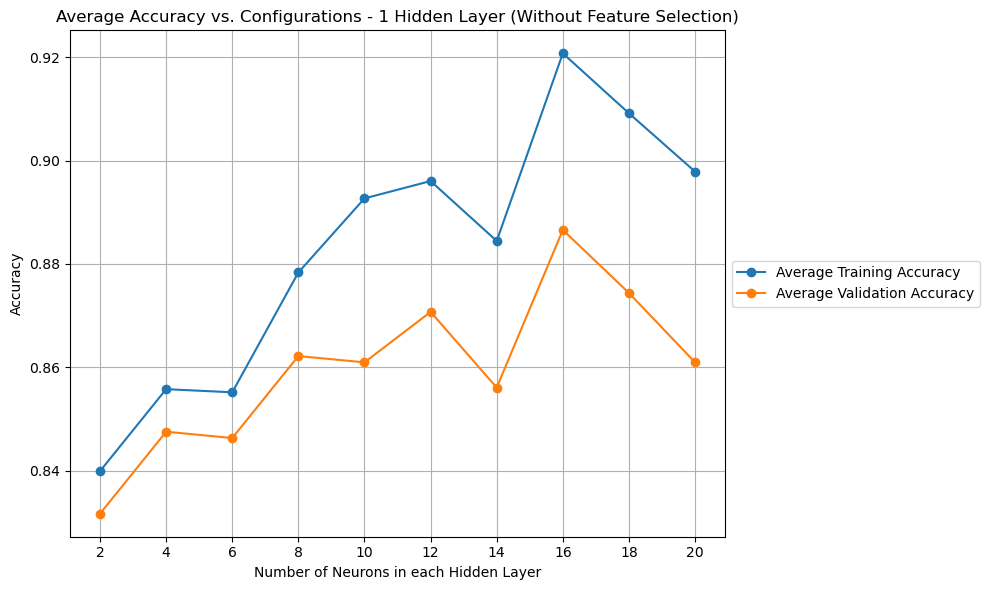

In [98]:
# Extract the training and validation accuracies for the configurations with only one hidden layer.
acc_train_one_layer = [mean_acc_train_all[i] for i in one_layer_idx]
acc_val_one_layer = [mean_acc_val_all[i] for i in one_layer_idx]

# Plot the mean training and validation accuracies for the different configurations with only one hidden layer.
plt.figure(figsize = (10, 6))
plt.plot(nr_neurons_one_layer, acc_train_one_layer, label = 'Average Training Accuracy', marker = 'o')
plt.plot(nr_neurons_one_layer, acc_val_one_layer, label = 'Average Validation Accuracy', marker = 'o')
plt.xticks(nr_neurons_one_layer)
plt.xlabel('Number of Neurons in each Hidden Layer')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs. Configurations - 1 Hidden Layer (Without Feature Selection)')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.grid(True)
plt.tight_layout()
plt.show()

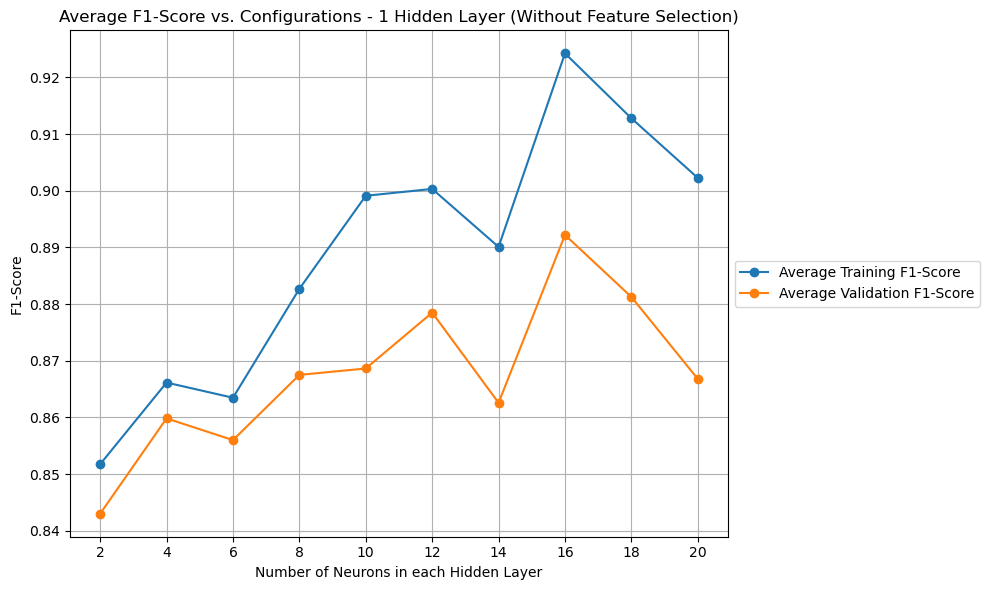

In [99]:
# Extract the training and validation F1-scores for the configurations with only one hidden layer.
F1_score_train_one_layer = [mean_F1_score_train_all[i] for i in one_layer_idx]
F1_score_val_one_layer = [mean_F1_score_val_all[i] for i in one_layer_idx]

# Plot the mean training and validation F1-scores for the different configurations with only one hidden layer.
plt.figure(figsize = (10, 6))
plt.plot(nr_neurons_one_layer, F1_score_train_one_layer, label = 'Average Training F1-Score', marker = 'o')
plt.plot(nr_neurons_one_layer, F1_score_val_one_layer, label = 'Average Validation F1-Score', marker = 'o')
plt.xticks(nr_neurons_one_layer)
plt.xlabel('Number of Neurons in each Hidden Layer')
plt.ylabel('F1-Score')
plt.title('Average F1-Score vs. Configurations - 1 Hidden Layer (Without Feature Selection)')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.grid(True)
plt.tight_layout()
plt.show()

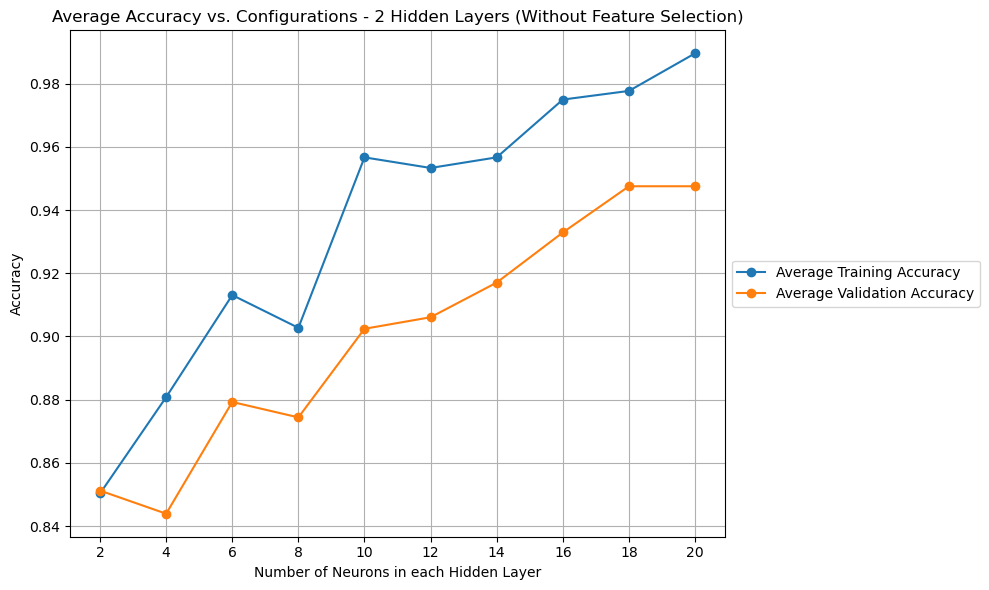

In [100]:
# Extract the training and validation accuracies for the configurations with only two hidden layers.
acc_train_two_layer = [mean_acc_train_all[i] for i in two_layer_idx]
acc_val_two_layer = [mean_acc_val_all[i] for i in two_layer_idx]

# Plot the mean training and validation accuracies for the different configurations with only two hidden layers.
plt.figure(figsize = (10, 6))
plt.plot(nr_neurons_two_layer, acc_train_two_layer, label = 'Average Training Accuracy', marker = 'o')
plt.plot(nr_neurons_two_layer, acc_val_two_layer, label = 'Average Validation Accuracy', marker = 'o')
plt.xticks(nr_neurons_two_layer)
plt.xlabel('Number of Neurons in each Hidden Layer')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs. Configurations - 2 Hidden Layers (Without Feature Selection)')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.grid(True)
plt.tight_layout()
plt.show()

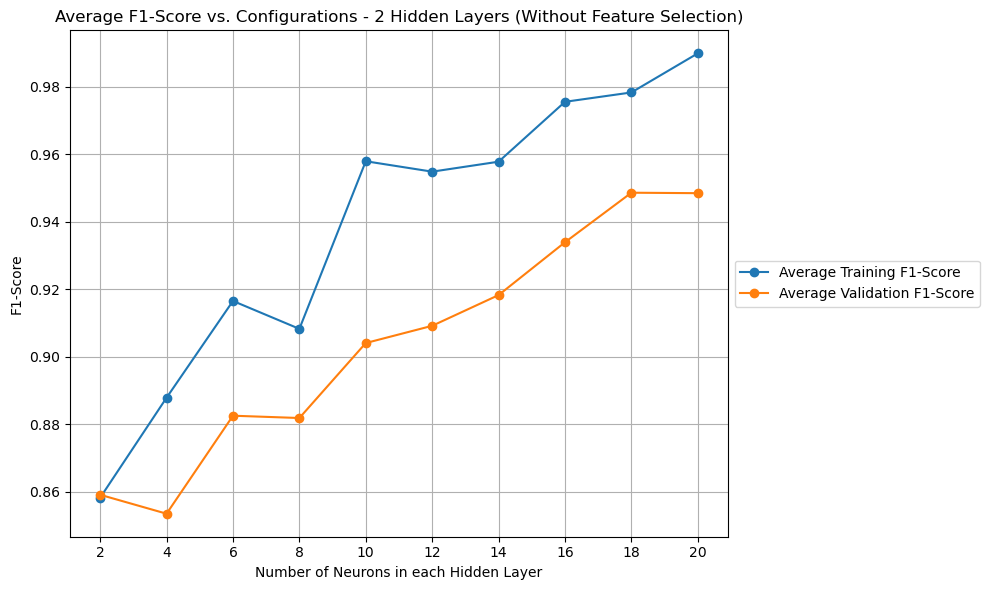

In [101]:
# Extract the training and validation F1-scores for the configurations with only two hidden layers.
F1_score_train_two_layer = [mean_F1_score_train_all[i] for i in two_layer_idx]
F1_score_val_two_layer = [mean_F1_score_val_all[i] for i in two_layer_idx]

# Plot the mean training and validation F1-scores for the different configurations with only two hidden layers.
plt.figure(figsize = (10, 6))
plt.plot(nr_neurons_two_layer, F1_score_train_two_layer, label = 'Average Training F1-Score', marker = 'o')
plt.plot(nr_neurons_two_layer, F1_score_val_two_layer, label = 'Average Validation F1-Score', marker = 'o')
plt.xticks(nr_neurons_two_layer)
plt.xlabel('Number of Neurons in each Hidden Layer')
plt.ylabel('F1-Score')
plt.title('Average F1-Score vs. Configurations - 2 Hidden Layers (Without Feature Selection)')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### With Feature Selection

In [102]:
# Set up the number of selected features to retain.
nr_selected_features = 9 # Number of selected features.

# # Select the top 9 features based on the ANOVA F-test with the target variable.
# feature_selector = SelectKBest(f_classif, k = nr_selected_features)

# Select the top 9 features based on the Mutual Information (MI) with the target variable.
feature_selector = SelectKBest(mutual_info_classif, k = nr_selected_features)

# Define the Multi-Layer Perceptron (MLP) classifier model.
mlp = MLPClassifier(max_iter = 1000, random_state = 42)

# Define the pipeline combining the feature selection and the MLP classifier.
pipeline = Pipeline([('feature_selection', feature_selector),
                     ('mlp', mlp)])

# Define the parameter grid to be searched by the GridSearchCV.
parameter_grid = {'mlp__hidden_layer_sizes': [(nr_neurons,) for nr_neurons in range(2, 20, 2)]
                  + [(nr_neurons, nr_neurons) for nr_neurons in range(2, 20, 2)]}

# Define the scoring metrics to be captured during the GridSearchCV.
scoring = {'accuracy': make_scorer(accuracy_score),
           'f1': make_scorer(f1_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'kappa': make_scorer(cohen_kappa_score)}

# Define the GridSearchCV object.
grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = parameter_grid,
                           scoring = scoring,
                           refit = 'f1', # Uses the F1-score to select the best model.
                           cv = skf,
                           return_train_score = True,
                           verbose = 1,
                           n_jobs = -1)

# Train and tune the model using the GridSearchCV.
grid_search.fit(X_train, y_train)

# Extract the best model, the best hyperparameter configuration, and the best validation F1-score
# found by the GridSearchCV.
best_model_fs = grid_search.best_estimator_
best_configuration_fs = grid_search.best_params_
best_f1_score_fs = grid_search.best_score_

# Extract the results of the GridSearchCV.
cv_results_fs = grid_search.cv_results_

# Extract and the mean and standard deviation of the validation performance metrics
# for the different hyperparameter configurations.
mean_acc_val_all = cv_results_fs['mean_test_accuracy']
mean_rec_val_all = cv_results_fs['mean_test_recall']
mean_prec_val_all = cv_results_fs['mean_test_precision']
mean_F1_score_val_all = cv_results_fs['mean_test_f1']
mean_kappa_val_all = cv_results_fs['mean_test_kappa']
std_acc_val_all = cv_results_fs['std_test_accuracy']
std_rec_val_all = cv_results_fs['std_test_recall']
std_prec_val_all = cv_results_fs['std_test_precision']
std_F1_score_val_all = cv_results_fs['std_test_f1']
std_kappa_val_all = cv_results_fs['std_test_kappa']

# Create a dictionary containing the mean and the standard deviation of the validation performance metrics
# for the different hyperparameter configurations.
metrics_dict_fs = {'Accuracy': (mean_acc_val_all, std_acc_val_all),
                     'Recall': (mean_rec_val_all, std_rec_val_all),
                     'Precision': (mean_prec_val_all, std_prec_val_all),
                     'F1-Score': (mean_F1_score_val_all, std_F1_score_val_all),
                     'Kappa': (mean_kappa_val_all, std_kappa_val_all)}

# Extract the mean and standard deviation of the training accuracy and F1-score,
# as well as the hyperparameter configurations, for plotting purposes.
mean_acc_train_all = cv_results_fs['mean_train_accuracy']
mean_F1_score_train_all = cv_results_fs['mean_train_f1']
configurations = cv_results_fs['param_mlp__hidden_layer_sizes']

# Print the mean and the standard deviation of the training and validation performance metrics
# for each hyperparameter configuration.
print('-'*50)
for i in range(len(configurations)):
    nr_layers = len(configurations[i])
    nr_neurons = configurations[i][0]
    print(f'Configuration (hidden layer structure): {nr_layers} hidden layers with {nr_neurons} neurons each')

    print('\nAverage performance metrics (training):')
    print(f'- Accuracy: {cv_results_fs['mean_train_accuracy'][i]:.3f} ± {cv_results_fs['std_train_accuracy'][i]:.3f}')
    print(f'- Recall: {cv_results_fs['mean_train_recall'][i]:.3f} ± {cv_results_fs['std_train_recall'][i]:.3f}')
    print(f'- Precision: {cv_results_fs['mean_train_precision'][i]:.3f} ± {cv_results_fs['std_train_precision'][i]:.3f}')
    print(f'- F1-Score: {cv_results_fs['mean_train_f1'][i]:.3f} ± {cv_results_fs['std_train_f1'][i]:.3f}')
    print(f'- Kappa: {cv_results_fs['mean_train_kappa'][i]:.3f} ± {cv_results_fs['std_train_kappa'][i]:.3f}')
    print('\nAverage performance metrics (validation):')
    print(f'- Accuracy: {cv_results_fs['mean_test_accuracy'][i]:.3f} ± {cv_results_fs['std_test_accuracy'][i]:.3f}')
    print(f'- Recall: {cv_results_fs['mean_test_recall'][i]:.3f} ± {cv_results_fs['std_test_recall'][i]:.3f}')
    print(f'- Precision: {cv_results_fs['mean_test_precision'][i]:.3f} ± {cv_results_fs['std_test_precision'][i]:.3f}')
    print(f'- F1-Score: {cv_results_fs['mean_test_f1'][i]:.3f} ± {cv_results_fs['std_test_f1'][i]:.3f}')
    print(f'- Kappa: {cv_results_fs['mean_test_kappa'][i]:.3f} ± {cv_results_fs['std_test_kappa'][i]:.3f}')
    print('-'*50)

# Print the best hyperparameter configuration and the best validation F1-Score.
best_nr_layers_fs = len(best_configuration_fs['mlp__hidden_layer_sizes'])
best_nr_neurons_fs = best_configuration_fs['mlp__hidden_layer_sizes'][0]
print(f'\nBest configuration (hidden layer structure): {best_nr_layers_fs} hidden layers with {best_nr_neurons_fs} neurons each')
print(f'Best validation F1-Score: {best_f1_score_fs:.3f}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
--------------------------------------------------
Configuration (hidden layer structure): 1 hidden layers with 2 neurons each

Average performance metrics (training):
- Accuracy: 0.825 ± 0.006
- Recall: 0.874 ± 0.019
- Precision: 0.803 ± 0.007
- F1-Score: 0.837 ± 0.007
- Kappa: 0.649 ± 0.012

Average performance metrics (validation):
- Accuracy: 0.815 ± 0.026
- Recall: 0.865 ± 0.031
- Precision: 0.794 ± 0.031
- F1-Score: 0.827 ± 0.024
- Kappa: 0.628 ± 0.052
--------------------------------------------------
Configuration (hidden layer structure): 1 hidden layers with 4 neurons each

Average performance metrics (training):
- Accuracy: 0.831 ± 0.014
- Recall: 0.873 ± 0.018
- Precision: 0.813 ± 0.012
- F1-Score: 0.842 ± 0.013
- Kappa: 0.662 ± 0.027

Average performance metrics (validation):
- Accuracy: 0.827 ± 0.026
- Recall: 0.872 ± 0.016
- Precision: 0.807 ± 0.031
- F1-Score: 0.838 ± 0.023
- Kappa: 0.653 ± 0.052
-------------

Talk about the feature selection...

In [103]:
# Extract the indices of the configurations that only have one hidden layer.
one_layer_idx = [i for i, config in enumerate(configurations) if len(config) == 1]

# Extract the indices of the configurations that only have two hidden layers.
two_layer_idx = [i for i, config in enumerate(configurations) if len(config) == 2]

# Extract the number of neurons for the configurations with only one hidden layer.
nr_neurons_one_layer = [configurations[i][0] for i in one_layer_idx]

# Extract the number of neurons for the configurations with only two hidden layers.
nr_neurons_two_layer = [configurations[i][0] for i in two_layer_idx]

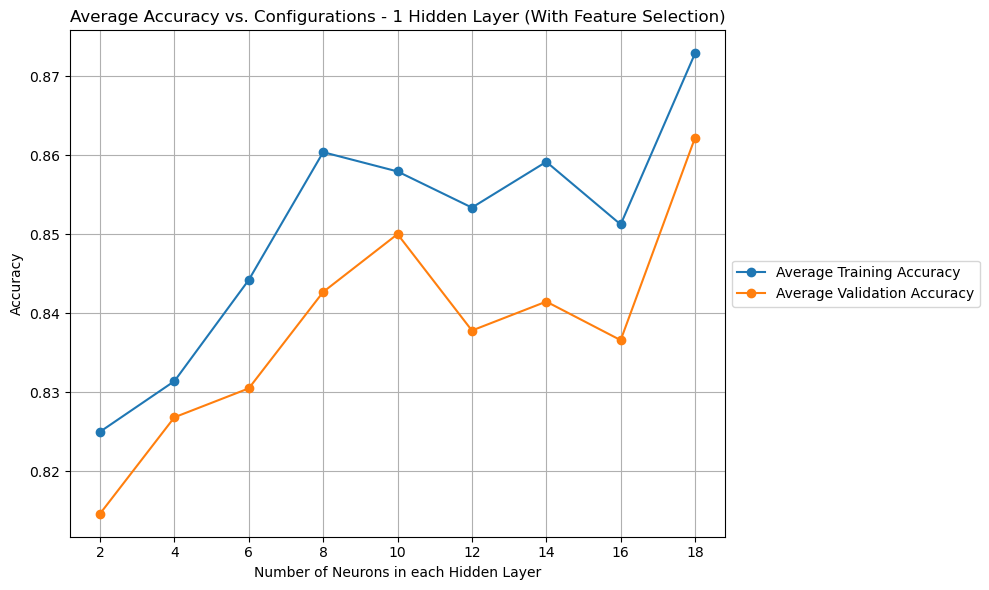

In [104]:
# Extract the training and validation accuracies for the configurations with only one hidden layer.
acc_train_one_layer = [mean_acc_train_all[i] for i in one_layer_idx]
acc_val_one_layer = [mean_acc_val_all[i] for i in one_layer_idx]

# Plot the mean training and validation accuracies for the different configurations with only one hidden layer.
plt.figure(figsize = (10, 6))
plt.plot(nr_neurons_one_layer, acc_train_one_layer, label = 'Average Training Accuracy', marker = 'o')
plt.plot(nr_neurons_one_layer, acc_val_one_layer, label = 'Average Validation Accuracy', marker = 'o')
plt.xticks(nr_neurons_one_layer)
plt.xlabel('Number of Neurons in each Hidden Layer')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs. Configurations - 1 Hidden Layer (With Feature Selection)')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.grid(True)
plt.tight_layout()
plt.show()

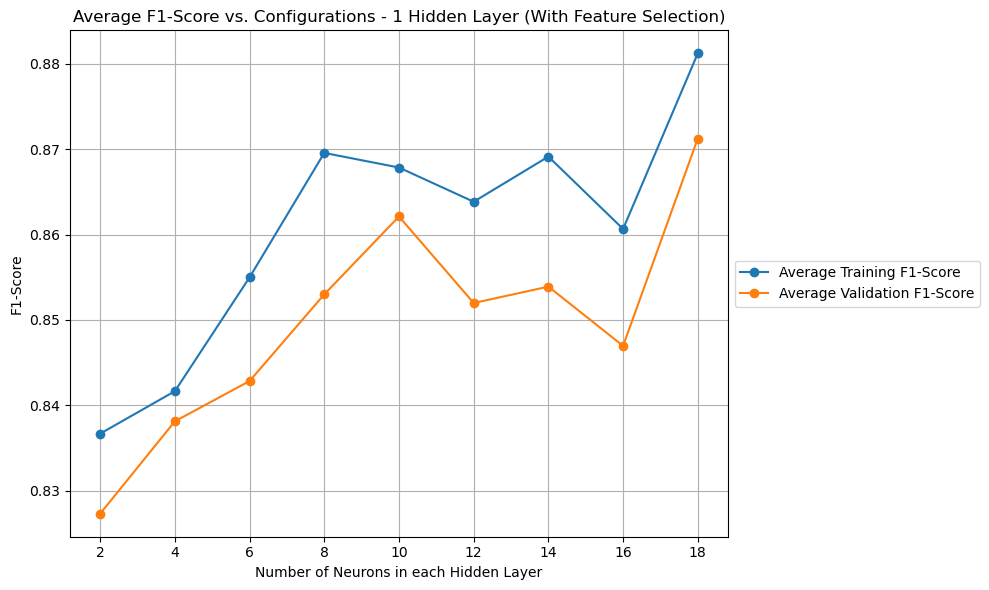

In [105]:
# Extract the training and validation F1-scores for the configurations with only one hidden layer.
F1_score_train_one_layer = [mean_F1_score_train_all[i] for i in one_layer_idx]
F1_score_val_one_layer = [mean_F1_score_val_all[i] for i in one_layer_idx]

# Plot the mean training and validation F1-scores for the different configurations with only one hidden layer.
plt.figure(figsize = (10, 6))
plt.plot(nr_neurons_one_layer, F1_score_train_one_layer, label = 'Average Training F1-Score', marker = 'o')
plt.plot(nr_neurons_one_layer, F1_score_val_one_layer, label = 'Average Validation F1-Score', marker = 'o')
plt.xticks(nr_neurons_one_layer)
plt.xlabel('Number of Neurons in each Hidden Layer')
plt.ylabel('F1-Score')
plt.title('Average F1-Score vs. Configurations - 1 Hidden Layer (With Feature Selection)')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.grid(True)
plt.tight_layout()
plt.show()

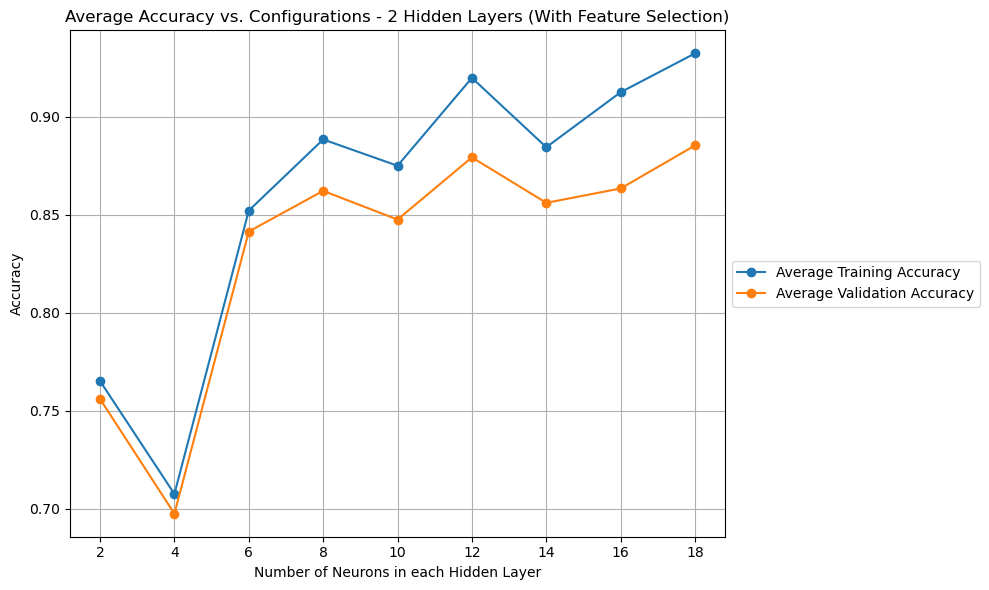

In [106]:
# Extract the training and validation accuracies for the configurations with only two hidden layers.
acc_train_two_layer = [mean_acc_train_all[i] for i in two_layer_idx]
acc_val_two_layer = [mean_acc_val_all[i] for i in two_layer_idx]

# Plot the mean training and validation accuracies for the different configurations with only two hidden layers.
plt.figure(figsize = (10, 6))
plt.plot(nr_neurons_two_layer, acc_train_two_layer, label = 'Average Training Accuracy', marker = 'o')
plt.plot(nr_neurons_two_layer, acc_val_two_layer, label = 'Average Validation Accuracy', marker = 'o')
plt.xticks(nr_neurons_two_layer)
plt.xlabel('Number of Neurons in each Hidden Layer')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs. Configurations - 2 Hidden Layers (With Feature Selection)')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.grid(True)
plt.tight_layout()
plt.show()

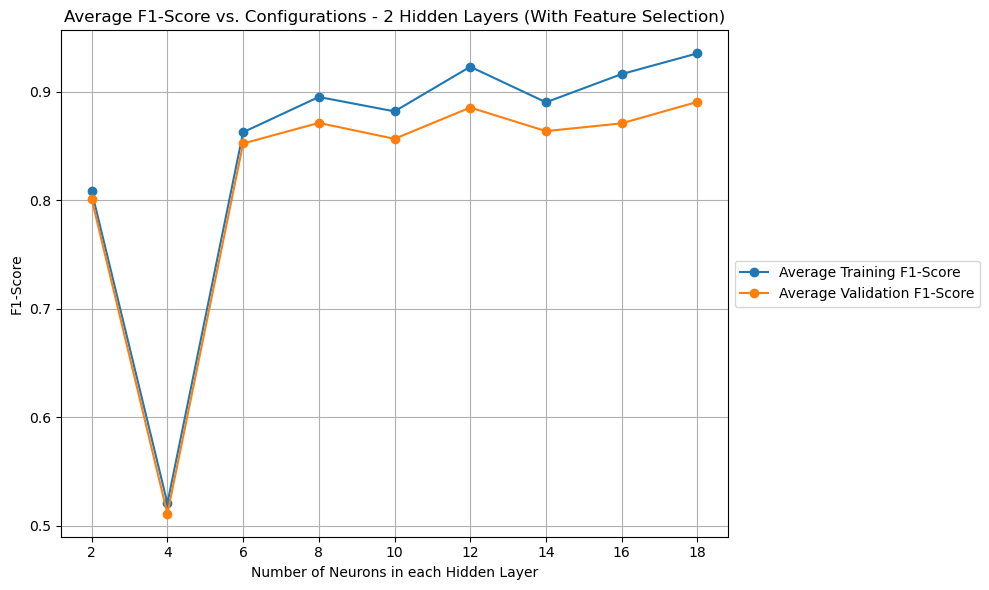

In [107]:
# Extract the training and validation F1-scores for the configurations with only two hidden layers.
F1_score_train_two_layer = [mean_F1_score_train_all[i] for i in two_layer_idx]
F1_score_val_two_layer = [mean_F1_score_val_all[i] for i in two_layer_idx]

# Plot the mean training and validation F1-scores for the different configurations with only two hidden layers.
plt.figure(figsize = (10, 6))
plt.plot(nr_neurons_two_layer, F1_score_train_two_layer, label = 'Average Training F1-Score', marker = 'o')
plt.plot(nr_neurons_two_layer, F1_score_val_two_layer, label = 'Average Validation F1-Score', marker = 'o')
plt.xticks(nr_neurons_two_layer)
plt.xlabel('Number of Neurons in each Hidden Layer')
plt.ylabel('F1-Score')
plt.title('Average F1-Score vs. Configurations - 2 Hidden Layers (With Feature Selection)')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Selecting the Final Model

In [108]:
# Set the manual_selection flag to "True" to select the final model manually.
manual_selection = False
if manual_selection:
    # Select the final model manually.
    nr_neurons = 5
    final_configuration = (nr_neurons, nr_neurons)
    feature_selection = False
else:
    # Select the final model based on the best validation F1-Score.
    if best_f1_score_full > best_f1_score_fs:
        final_model = best_model_full
    else:
        final_model = best_model_fs

In [109]:
if manual_selection:
    if feature_selection:
        # # Select the top 9 features based on the ANOVA F-test with the target variable.
        # feature_selector = SelectKBest(f_classif, k = nr_selected_features)

        # Select the top 9 features based on the Mutual Information (MI) with the target variable.
        feature_selector = SelectKBest(mutual_info_classif, k = nr_selected_features)

        # Fit the feature selector on the original training set and transform the data.
        X_train_final = feature_selector.fit_transform(X_train, y_train)

        # Transform the testing set using the same selected features.
        X_test_final = feature_selector.transform(X_test)
    else:
        # Use all the features.
        X_train_final = X_train
        X_test_final = X_test

    # Define the Multi-Layer Perceptron (MLP) classifier model.
    final_model = MLPClassifier(hidden_layer_sizes = final_configuration, max_iter = 1000, random_state = 42)

    # Train the final model.
    final_model.fit(X_train_final, y_train)
else:
    X_test_final = X_test

Explain how we select the final model.

### Model Evaluation (Testing)

Test performance metrics for the final model:
- Accuracy: 0.927
- Recall: 0.943
- Precision: 0.917
- F1-Score: 0.930
- Kappa Score: 0.853

Confusion matrix for the final model:
[[91  9]
 [ 6 99]]


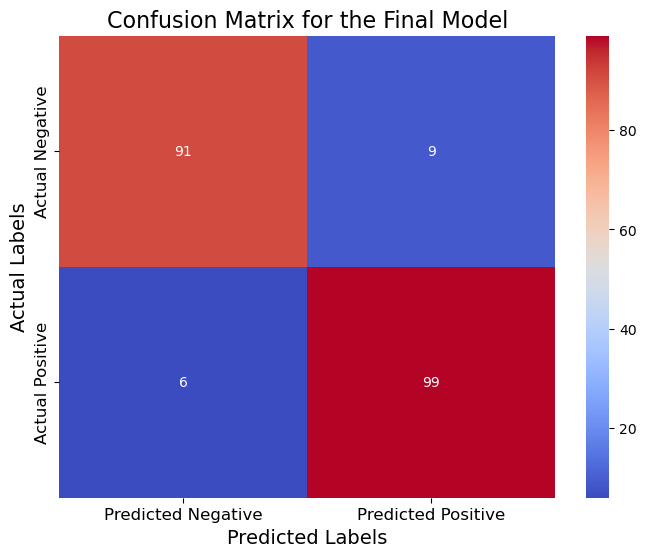

In [110]:
# Get the final model predictions.
y_pred = final_model.predict(X_test_final)

# Compute the test perfomance metrics for the final model.
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# Print the test performance metrics for the final model.
print('Test performance metrics for the final model:')
print(f'- Accuracy: {acc:.3f}')
print(f'- Recall: {rec:.3f}')
print(f'- Precision: {prec:.3f}')
print(f'- F1-Score: {F1_score:.3f}')
print(f'- Kappa Score: {kappa:.3f}')

# Compute the confusion matrix for the final model.
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix for the final model.
print(f'\nConfusion matrix for the final model:\n{cm}')

# Plot the confusion matrix for the final model.
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'coolwarm',
            xticklabels = ['Predicted Negative', 'Predicted Positive'],
            yticklabels = ['Actual Negative', 'Actual Positive'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Predicted Labels', fontsize = 14)
plt.ylabel('Actual Labels', fontsize = 14)
plt.title('Confusion Matrix for the Final Model', fontsize = 16)
plt.show()